In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import matplotlib.colors as mcolors

# Plot styling
axes_size = 20
tick_size = 18
rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Times"]
rcParams["font.size"] = tick_size
rcParams["axes.labelsize"] = axes_size
rcParams["xtick.labelsize"] = tick_size
rcParams["ytick.labelsize"] = tick_size
rcParams["legend.fontsize"] = tick_size

# Load data
file_path = '../output/straight/latest_100_IDM_FS_followers_7.csv'
df = pd.read_csv(file_path)

In [4]:
def plot_relative_speed(csv_path, xlim=(0, None), ylim=(None, None), 
                                       save_pdf=False, save_path=None, fig_size=(10, 4), dpi=300, freq=100):
    """
    Plot relative speed as (predecessor - current) to capture closing or increasing gaps.
    """
    df = pd.read_csv(csv_path)
    speed_df = df.pivot(index='time_step', columns='role', values='speed_mps')

    # Ensure logical order: Leader, Follower1, Follower2, ...
    sorted_roles = ['Leader'] + sorted([col for col in speed_df.columns if col != 'Leader'])

    # print(sorted_roles)

    rel_speed_diff = pd.DataFrame(index=speed_df.index)

    for i in range(1, len(sorted_roles)):
        curr_role = sorted_roles[i]
        prev_role = sorted_roles[i - 1]

        # print("Current: "+curr_role+" Previous: "+prev_role)
        # Leader - current
        rel_speed_diff[curr_role] = speed_df[prev_role] - speed_df[curr_role]

    time_seconds = rel_speed_diff.index / freq

    plt.figure(figsize=fig_size)
    for col in rel_speed_diff.columns:
        plt.plot(time_seconds, rel_speed_diff[col], label=col)

    plt.xlabel("Time (s)")
    plt.ylabel("Relative Speed (m/s)")
    plt.title("Relative Speed Between Vehicles")
    plt.legend(ncols=2)
    if xlim != (0, None): plt.xlim(xlim)
    if ylim != (None, None): plt.ylim(ylim)
    plt.grid(True)

    if save_pdf:
        if not save_path:
            save_path = "relative_speed_plot.pdf"
        plt.savefig(save_path, format='pdf', dpi=dpi, bbox_inches='tight')

    plt.show()


def plot_headway_direct(csv_path, xlim=(0, None), ylim=(None, None), 
                        save_pdf=False, save_path=None, fig_size=(10, 4), dpi=300, freq=100):
    """
    Plot the space headway for each vehicle over time.
    """
    df = pd.read_csv(csv_path)
    headway_df = df.pivot(index='time_step', columns='role', values='space_headway')

    headway_df = headway_df.drop(columns='Leader')  # Leader's headway is zero and not meaningful

    time_seconds = headway_df.index / freq

    plt.figure(figsize=fig_size)
    for col in headway_df.columns:
        plt.plot(time_seconds, headway_df[col], label=col)

    plt.xlabel("Time (s)")
    plt.ylabel("Space Headway (m)")
    plt.title("Headway Over Time for Each Follower")
    plt.legend(ncols=2)
    if xlim != (0, None): plt.xlim(xlim)
    if ylim != (None, None): plt.ylim(ylim)
    plt.grid(True)

    if save_pdf:
        if not save_path:
            save_path = "space_headway_plot.pdf"
        plt.savefig(save_path, format='pdf', dpi=dpi, bbox_inches='tight')

    plt.show()


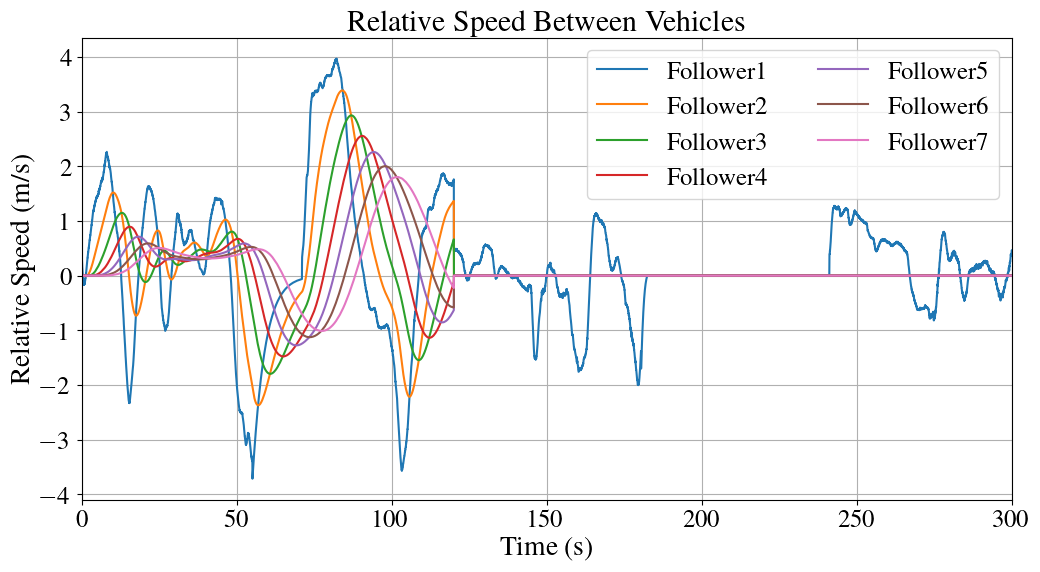

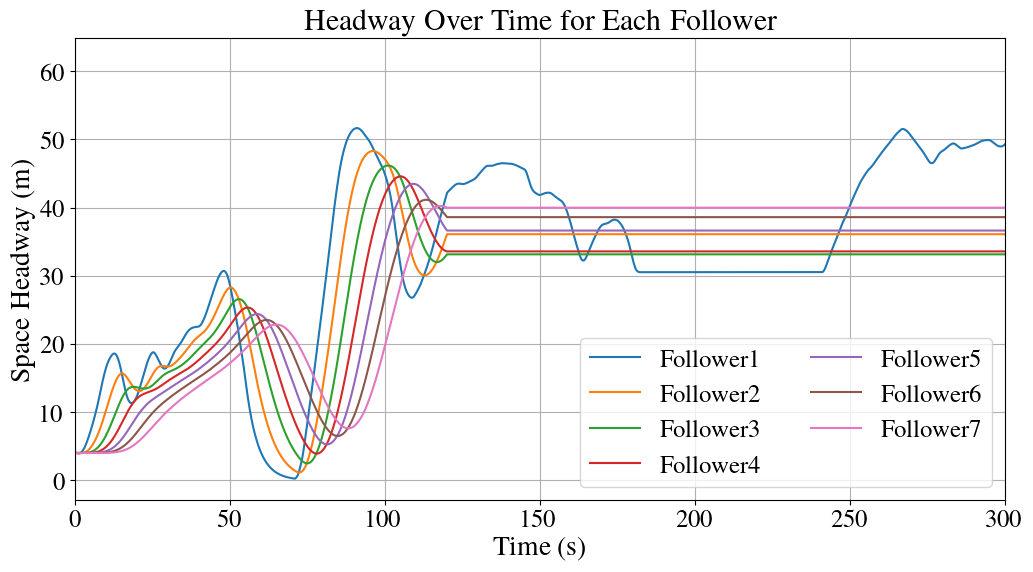

In [5]:
plot_relative_speed(file_path,
                    xlim=(0, 300),
                    ylim=(None, None), 
                    fig_size=(12, 6))
plot_headway_direct(file_path,
                    xlim=(0, 300),
                    ylim=(None, None), 
                    fig_size=(12, 6))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_head_to_tail_amplification(csv_path, follower_role='Follower6',
                                    t_start_s=0, t_end_s=None, freq=100,
                                    xlim=(0, None), ylim=(None, None),
                                    save_pdf=False, save_path=None,
                                    fig_size=(10, 3), dpi=300):
    """
    Plot time-varying head-to-tail amplification:
        A_t(t) = |v_follower(t) - veq| / |v_leader(t) - veq|

    Parameters:
    - csv_path: path to CSV log file
    - follower_role: role of the last follower (e.g., 'Follower6')
    - t_start_s, t_end_s: time window in seconds
    - freq: frequency in Hz (default 100)
    - xlim, ylim: axes limits for plot
    - save_pdf: whether to save the figure
    - save_path: file path to save figure
    - fig_size, dpi: figure size and resolution

    Returns:
    - dict with summary stats
    """
    # Load CSV
    df = pd.read_csv(csv_path)
    df = df[['time_step', 'role', 'speed_mps']]

    # Compute equilibrium speed (overall mean)
    veq = df['speed_mps'].mean()
    print(f"Equilibrium velocity: {veq:.5f} m/s")

    # Pivot to time_step × role
    speed_df = df.pivot(index='time_step', columns='role', values='speed_mps').dropna()

    # Slice time window
    time_step_size = 1 / freq
    if t_end_s is None:
        t_end_s = speed_df.index.max() * time_step_size
    t_start_idx = int(t_start_s / time_step_size)
    t_end_idx = int(t_end_s / time_step_size)
    window_df = speed_df.iloc[t_start_idx:t_end_idx]

    # Extract speed vectors
    leader_speed = window_df['Leader']
    follower_speed = window_df[follower_role]

    # Compute absolute deviation from veq
    leader_dev = (leader_speed - veq).abs()
    follower_dev = (follower_speed - veq).abs()

    # Compute amplification A_t(t)
    with pd.option_context('mode.use_inf_as_na', True):
        A_t = follower_dev / leader_dev.replace(0, pd.NA)
        A_t = A_t.fillna(0)

    # Time in seconds
    time_sec = window_df.index * time_step_size

    # Summary stats
    max_A = A_t.max()
    mean_A = A_t.mean()
    min_A = A_t.min()
    percent_A_lt1 = (A_t < 1).mean() * 100

    print(f"Time Window: {t_start_s}s to {t_end_s}s")
    print(f"Max A_t: {max_A:.4f}")
    print(f"Mean A_t: {mean_A:.4f}")
    print(f"Min A_t: {min_A:.4f}")
    print(f"Percentage of Time A_t < 1: {percent_A_lt1:.2f}%")

    # Plot
    plt.figure(figsize=fig_size)
    plt.plot(time_sec, A_t, label=fr"$A_t(t) = \frac{{|v_{{{follower_role}}} - v_{{eq}}|}}{{|v_{{Leader}} - v_{{eq}}|}}$", color='darkblue')
    plt.axhline(1.0, color='gray', linestyle='--', label='Threshold A=1')
    plt.xlabel("Time (s)")
    plt.ylabel(r"$A_t(t)$")
    plt.title("Head-to-Tail Amplification Over Time")
    plt.legend()
    plt.grid(True)

    if xlim != (0, None): plt.xlim(xlim)
    if ylim != (None, None): plt.ylim(ylim)

    if save_pdf:
        if save_path is None:
            save_path = "head_to_tail_amplification.pdf"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format="pdf", dpi=dpi)
        print(f"Saved to {save_path}")

    plt.tight_layout()
    plt.show()

    return {
        'max_A': max_A,
        'mean_A': mean_A,
        'min_A': min_A,
        'percent_A_lt1': percent_A_lt1
    }


Equilibrium velocity: 15.67891 m/s
Time Window: 0s to 600s
Max A_t: 366.8758
Mean A_t: 1.3074
Min A_t: 0.0014
Percentage of Time A_t < 1: 41.68%


/tmp/ipykernel_1530182/3315288132.py:55: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


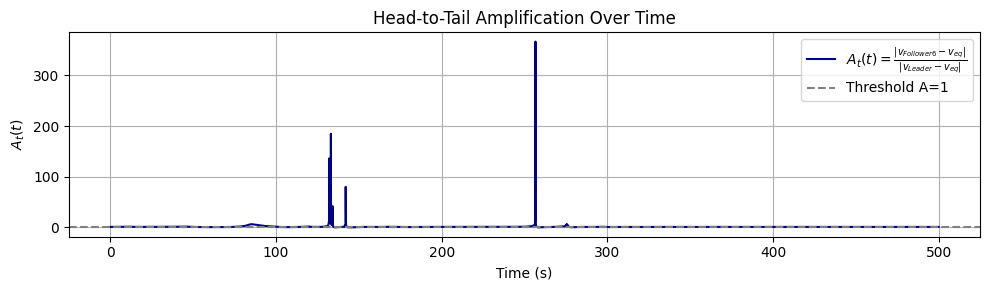

In [5]:
csv_path = "../output/straight/latest_50_IDM_FS_followers_7.csv"
summary = plot_head_to_tail_amplification(csv_path,
                                          follower_role='Follower6',
                                          t_start_s=0,
                                          t_end_s=600,
                                          freq=50)
